In [1]:
import pandas as pd 
import numpy as np
import keras 
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Loading Data

(x_train, y_train), (x_test,y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
# Getting shapes

print(x_train.shape)
print(x_test.shape)
input_shape = (32,32,3)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [0]:
# Converting to float32 and normalizing data

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/255.0
x_test = x_test/255.0 

In [0]:
# Spliting into train and validation set

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=45)

In [0]:
# Settig up callback methods for time tracking

import time
import keras
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
        self.losses = []
        self.lr = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
    
def getTrainingTime(times):
      tot = 0
      for i in times:
        tot = tot+i
      return tot

In [0]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import reciprocal, uniform
# param_distributions = {lr:uniform(0.001, 0.01)} 
# rnd_search_cv = RandomizedSearchCV(model., param_distributions, n_jobs=-1, verbose=2, cv=3, random_state=42)
# rnd_search_cv.fit(x_train, y_train)

# rnd_search_cv.best_estimator_
# 0.01 ->0.0055 -> 0.001
from keras.callbacks import LearningRateScheduler

# def step_decay(epoch):
#     lrate = 0.01
#     if epoch >= 7:
#         lrate = 0.0055
#     if epoch >= 14:
#         lrate = 0.001
#     return lrate
# lrate = LearningRateScheduler(step_decay)

# from keras.callbacks import LearningRateScheduler
# def step_decay(epoch):
#     lrate = 0.01
#     if epoch > 7:
#         lrate = 0.0055
#     if epoch > 12:
#         lrate = 0.0032
#     if epoch > 15:
#         lrate = 0.001
#     return lrate
# lrate = LearningRateScheduler(step_decay)

# def step_decay(epoch):
    # lrate = 0.01
    # if epoch >= 11:
        # lrate = 0.0050
    # if epoch >= 14:
        # lrate = 0.0025
    # if epoch >= 17:
        # lrate = 0.001
    # if epoch >= 21:
    #     lrate = 0.0008
    # return lrate
# lrate = LearningRateScheduler(step_decay)

# trying the upper half ranges of lr for faster convergence
# def step_decay(epoch):
#     lrate = 0.01
#     if epoch >= 11:
#         lrate = 0.0075
#     if epoch >= 17:
#         lrate = 0.0050
#     if epoch >= 23:
#         lrate = 0.0025
#     return lrate
# lrate = LearningRateScheduler(step_decay)

# trying higher kr at beg near 0.01
# def step_decay(epoch):
#     lrate = 0.02
#     if epoch >= 28:
#         lrate = 0.015
#     if epoch >= 42:
#         lrate = 0.010
#     if epoch >= 49:
#         lrate = 0.005
#     if epoch >= 52:
#         lrate = 0.001
#     return lrate
# lrate = LearningRateScheduler(step_decay)

def step_decay(epoch):
    lrate = 0.02
    if epoch >= 14:
        lrate = 0.010
    if epoch >= 28:
        lrate = 0.005
    if epoch >= 42:
        lrate = 0.001
    return lrate
lrate = LearningRateScheduler(step_decay)


In [0]:
# Creating Model without batch normalization it wasnt even fitting top 20 examples(acc = 0.05, 0.10) gradaually adding 
# batch noramlization layers to the model after conv layer made it overfit those examples, last dense layer when kept result in loss of 0.7053
# and acc = 0.95 but its removal overfits this data (20 egs) so this sanity check instantly provided with solutions to archi problems
# Addition of batch norm layers added some regularization also and its removal increases the loss so its a good sanity check
# After training for 30 epochs with sgd optimizer (lr = 0.001 with no momentum) training loss was good with 91% acu but 
# test loss =1.10 acu = 66.90 so tried adam optimizer with default value it resulted in good train(0.053 98.3) and val loss (1.91 72.6) so 
# adam seems a good choice with two momentums also after drawing curves it became apparent lr is high since it platued fast with 
# a steep initial drop . When trained with sgd (0.01 , 0.1 m) it gave a small boost to accur with (1.14, 67.5)on val (0.2828, 91.5) on train
# but the plot shows a steep decline which is becoz of low learning rate, to see the effect of momnetum on sgd model was trained with (0.01,0.9)
# it reduced training time with fast convergence it also increased val loss and acu = (1.40(^),73.35) seeing the curve of loss its apparent that
# lr is low so checking with a bit high lr = 0.01 it lowered traning losses and accuracy and also decresed val accuracy to (1.20, 73.26)
# tried with higher lr = 0.1 but loss exploded so lr must belong to (0.001, 0.01). TRied with step decay on epochs but model was so overfitting 
# so initiating model wth dropout into fc layers. with just one dropout and defined lr schedule the validation accu increased to (77.21 
# & loss 1.29) trainng loss and acc is 0.03 98.35. Tried with two dropouts in fcs but same rate schedule as prev one the model still overfits
# and platues at last epochs val acc was 77.16 so a bit adjustment in rate schedule and regularization needed. Increasing dropouts layers reduced 
# overfitting. The new rate sched and model has val acc 79.42 and loss 0.73 and train acc 92.29 loss 0.2189. When trained new model with prev rate
# schedule for 21 epoch results were slightly better but the validation acc seems to platue after 10 epochs but then decreased, also rate=0.01 of 
# increased loss after 10 epochs so doing some updates in schedule also it was noticed that 0.001 rate is making no chages in steps so decreasing
# it a bit to 0.0008. Top 11 epochs are good but decreasing lr a lot decreases the step size so it might require more epochs. Again trained with
# some higher rates closer to 0.01 (75,50,25)(also trained with 0.001 then for 10 epochs) but not achievng much difference result is close 
# to 78% accu in validataion and still overfitting. So gonna use the first schedule only and apply kernel regularizer to regulate weights 
# results produced were good indications till 21 epocs with val acu of 79.50 and train accu 0f 90 %. Then tried with weight decay of 1e-5 
# results were loss: 0.2493 - accuracy: 0.9137 - val_loss: 0.7177 - val_accuracy: 0.7983 (best till) but still it is platuing so might requie
# extra epochs and start from higher(0.02 maybe) lr . Some reduction in regularization could also work. When tried higher lr first it gave fast
# learning and extra steps to learn 0.02 works good, trained till 60 epochs with fifth sched and val accu reached 80 but graph shows req of regul.
# using adam with above also produced simillar results adam with 0.001 without kernel regul produced 79% and 0.01 produced 80% val accu
# Applied data augm and it resulted in increase in val accu to 84% bu model became underfitting so removing two 0.4 dropouts to 0.2 this stopped 
# underfit of model and model fittted training and test data beautifully. Used data augmentation wit hsgd but ot didnt improved performance.

weight_decay = 1e-5
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3,3), strides = 1, padding = 'same', activation = tf.nn.relu, kernel_regularizer= regularizers.l2(weight_decay),  input_shape = (32,32,3)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 1, padding = 'same', activation = tf.nn.relu, kernel_regularizer= regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.2))
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 1, padding = 'same', activation = tf.nn.relu, kernel_regularizer= regularizers.l2(weight_decay)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = 1, padding = 'same', activation = tf.nn.relu, kernel_regularizer= regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.2))
model.add(Flatten())
model.add(Dense(units = 128,activation = tf.nn.relu, kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(rate = 0.2 ))
model.add(Dense(units = 128,activation = tf.nn.relu, kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(Dropout(rate = 0.2 ))
#model.add(Dense(units = 128,activation = tf.nn.relu))
model.add(Dropout(rate = 0.2 ))
model.add(Dense(units = 10, activation = tf.nn.softmax))


In [0]:
sgd = keras.optimizers.sgd(lr = 0.001, momentum = 0.9, nesterov=False)

model.compile(optimizer= sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

time_callback = TimeHistory()
loss_history = TimeHistory()
lrate = LearningRateScheduler(step_decay)

history = model.fit(  x = x_train, y = y_train, validation_data=(x_val, y_val), epochs = 30, callbacks = [time_callback, loss_history, lrate])

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 184s 5ms/step - loss: 1.6525 - accuracy: 0.4061 - val_loss: 1.4263 - val_accuracy: 0.4977
Epoch 2/30
40000/40000 [==============================] - 186s 5ms/step - loss: 1.2703 - accuracy: 0.5554 - val_loss: 1.0867 - val_accuracy: 0.6225
Epoch 3/30
40000/40000 [==============================] - 182s 5ms/step - loss: 1.0617 - accuracy: 0.6354 - val_loss: 1.0682 - val_accuracy: 0.6296
Epoch 4/30
40000/40000 [==============================] - 183s 5ms/step - loss: 0.9290 - accuracy: 0.6796 - val_loss: 0.8358 - val_accuracy: 0.7109
Epoch 5/30
40000/40000 [==============================] - 185s 5ms/step - loss: 0.8422 - accuracy: 0.7098 - val_loss: 0.7974 - val_accuracy: 0.7227
Epoch 6/30
40000/40000 [==============================] - 181s 5ms/step - loss: 0.7787 - accuracy: 0.7307 - val_loss: 0.7924 - val_accuracy: 0.7261
Epoch 7/30
40000/40000 [==============================] - 182s

In [0]:
# some extraa steps
sgd = keras.optimizers.sgd(lr = 0.02, momentum = 0.9, nesterov=False)

model.compile(optimizer= sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

time_callback = TimeHistory()
loss_history = TimeHistory()
lrate = LearningRateScheduler(step_decay)

history = model.fit(  x = x_train, y = y_train, validation_data=(x_val, y_val), epochs = 60, callbacks = [time_callback, loss_history, lrate])

Train on 40000 samples, validate on 10000 samples
Epoch 1/60
40000/40000 [==============================] - 12s 290us/step - loss: 1.7908 - accuracy: 0.3573 - val_loss: 1.5655 - val_accuracy: 0.4380
Epoch 2/60
40000/40000 [==============================] - 11s 270us/step - loss: 1.3685 - accuracy: 0.5171 - val_loss: 1.2804 - val_accuracy: 0.5563
Epoch 3/60
40000/40000 [==============================] - 11s 271us/step - loss: 1.1948 - accuracy: 0.5866 - val_loss: 1.1769 - val_accuracy: 0.6019
Epoch 4/60
40000/40000 [==============================] - 11s 270us/step - loss: 1.0818 - accuracy: 0.6327 - val_loss: 1.0012 - val_accuracy: 0.6544
Epoch 5/60
40000/40000 [==============================] - 11s 273us/step - loss: 1.0010 - accuracy: 0.6618 - val_loss: 1.0377 - val_accuracy: 0.6545
Epoch 6/60
40000/40000 [==============================] - 11s 268us/step - loss: 0.9439 - accuracy: 0.6864 - val_loss: 0.9139 - val_accuracy: 0.6878
Epoch 7/60
40000/40000 [==============================] 

In [0]:
model.evaluate(x_val,y_val)  # second sched...

10000/10000 [==============================] - 12s 1ms/step


[0.7369107859134674, 0.7942000031471252]

In [0]:
sgd = keras.optimizers.sgd(lr = 0.01, momentum = 0.9, nesterov=False)

model.compile(optimizer= sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

time_callback = TimeHistory()
loss_history = TimeHistory()
lrate = LearningRateScheduler(step_decay)

history = model.fit(  x = x_train, y = y_train, validation_data=(x_val, y_val),epochs= 10, callbacks = [time_callback, loss_history, lrate])

Train on 40000 samples, validate on 10000 samples
Epoch 1/21
40000/40000 [==============================] - 180s 4ms/step - loss: 1.6846 - accuracy: 0.3913 - val_loss: 1.4000 - val_accuracy: 0.4861
Epoch 2/21
40000/40000 [==============================] - 182s 5ms/step - loss: 1.2479 - accuracy: 0.5563 - val_loss: 1.0828 - val_accuracy: 0.6158
Epoch 3/21
40000/40000 [==============================] - 179s 4ms/step - loss: 1.0528 - accuracy: 0.6320 - val_loss: 0.9431 - val_accuracy: 0.6662
Epoch 4/21
40000/40000 [==============================] - 179s 4ms/step - loss: 0.9211 - accuracy: 0.6779 - val_loss: 0.8436 - val_accuracy: 0.7147
Epoch 5/21
40000/40000 [==============================] - 183s 5ms/step - loss: 0.8375 - accuracy: 0.7085 - val_loss: 0.8210 - val_accuracy: 0.7170
Epoch 6/21
40000/40000 [==============================] - 180s 5ms/step - loss: 0.7566 - accuracy: 0.7398 - val_loss: 0.7840 - val_accuracy: 0.7309
Epoch 7/21
40000/40000 [==============================] - 181s

In [0]:
model.evaluate(x_val,y_val)

10000/10000 [==============================] - 12s 1ms/step


[0.6920508768558502, 0.795799970626831]

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# prepare iterator
it_train = datagen.flow(x_train, y_train, batch_size = 64)

steps = int(x_train.shape[0] / 64)


In [26]:
# with data augmentation

sgd = keras.optimizers.sgd(lr = 0.01, momentum = 0.9, nesterov=False)
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


time_callback = TimeHistory()
loss_history = TimeHistory()
val_steps = int(x_val.shape[0]/128)
lrate = LearningRateScheduler(step_decay)

history = model.fit(it_train, validation_data=(x_val, y_val), epochs= 150, callbacks = [time_callback, loss_history, lrate], steps_per_epoch = steps, validation_steps= steps)

Epoch 1/150
625/625 [==============================] - 19s 31ms/step - loss: 1.8418 - accuracy: 0.3317 - val_loss: 1.4572 - val_accuracy: 0.4755
Epoch 2/150
625/625 [==============================] - 19s 30ms/step - loss: 1.5369 - accuracy: 0.4406 - val_loss: 1.4017 - val_accuracy: 0.4956
Epoch 3/150
625/625 [==============================] - 18s 29ms/step - loss: 1.4083 - accuracy: 0.4927 - val_loss: 1.2600 - val_accuracy: 0.5481
Epoch 4/150
625/625 [==============================] - 18s 29ms/step - loss: 1.3031 - accuracy: 0.5320 - val_loss: 1.1617 - val_accuracy: 0.5935
Epoch 5/150
625/625 [==============================] - 18s 30ms/step - loss: 1.2309 - accuracy: 0.5609 - val_loss: 1.3166 - val_accuracy: 0.5581
Epoch 6/150
625/625 [==============================] - 19s 30ms/step - loss: 1.1602 - accuracy: 0.5871 - val_loss: 1.2104 - val_accuracy: 0.5861
Epoch 7/150
625/625 [==============================] - 18s 29ms/step - loss: 1.1243 - accuracy: 0.6027 - val_loss: 0.9503 - val_ac

In [0]:
print("Train time with sgd 1e3, m = 0.1:",int(getTrainingTime(time_callback.times)//60),"minutes")

Train time with sgd 1e3, m = 0.1: 81 minutes


In [0]:
print("Train time with sgd 1e3, m = 0.9 15 epochs:",int(getTrainingTime(time_callback.times)//60),"minutes")

Train time with sgd 1e3, m = 0.9 15 epochs: 41 minutes


In [0]:
print("Train time with sgd lr rate schedule, m = 0.9 30 epochs:",int(getTrainingTime(time_callback.times)//60),"minutes") (with one dropout)

Train time with sgd 1e3, m = 0.9 15 epochs: 83 minutes


In [0]:
print("Train time with sgd lr rate schedule, m = 0.9 30 epochs:",int(getTrainingTime(time_callback.times)//60),"minutes") #(with two dropout)

Train time with sgd lr rate schedule, m = 0.9 30 epochs: 82 minutes


In [0]:
import pickle
outfile = open('model_adam_0.001','wb')
pickle.dump(model,outfile)
outfile.close()

In [0]:
# Model for use with Adam


weight_decay = 1e-5
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3,3), strides = 1, padding = 'same', activation = tf.nn.relu, input_shape = (32,32,3)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 1, padding = 'same', activation = tf.nn.relu ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.2))
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 1, padding = 'same', activation = tf.nn.relu))
model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = 1, padding = 'same', activation = tf.nn.relu))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.2))
model.add(Flatten())
model.add(Dense(units = 128,activation = tf.nn.relu))
model.add(Dropout(rate = 0.2 ))
model.add(Dense(units = 128,activation = tf.nn.relu))
#model.add(Dropout(rate = 0.2 ))
#model.add(Dense(units = 128,activation = tf.nn.relu))
model.add(Dropout(rate = 0.2 ))
model.add(Dense(units = 10, activation = tf.nn.softmax))


In [0]:
# Final Model Using Sigmoid activations
weigh1t_decay = 1e-5
model1 = Sequential()
model1.add(Conv2D(filters = 16, kernel_size = (3,3), strides = 1, padding = 'same', activation = tf.nn.sigmoid, input_shape = (32,32,3)))
model1.add(BatchNormalization())
model1.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 1, padding = 'same', activation = tf.nn.sigmoid ))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(rate = 0.2))
model1.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 1, padding = 'same', activation = tf.nn.sigmoid))
model1.add(Conv2D(filters = 64, kernel_size = (3,3), strides = 1, padding = 'same', activation = tf.nn.sigmoid))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(rate = 0.2))
model1.add(Flatten())
model1.add(Dense(units = 128,activation = tf.nn.sigmoid))
model1.add(Dropout(rate = 0.2 ))
model1.add(Dense(units = 128,activation = tf.nn.sigmoid))
#mode1l.add(Dropout(rate = 0.2 ))
#mode1l.add(Dense(units = 128,activation = tf.nn.relu))
model1.add(Dropout(rate = 0.2 ))
model1.add(Dense(units = 10, activation = tf.nn.softmax))


In [0]:
# Final Model Using Tanh activations
weigh1t_decay = 1e-5
model1 = Sequential()
model1.add(Conv2D(filters = 16, kernel_size = (3,3), strides = 1, padding = 'same', activation = tf.nn.tanh, input_shape = (32,32,3)))
model1.add(BatchNormalization())
model1.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 1, padding = 'same', activation = tf.nn.tanh ))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(rate = 0.2))
model1.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 1, padding = 'same', activation = tf.nn.tanh))
model1.add(Conv2D(filters = 64, kernel_size = (3,3), strides = 1, padding = 'same', activation = tf.nn.tanh))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(rate = 0.2))
model1.add(Flatten())
model1.add(Dense(units = 128,activation = tf.nn.tanh))
model1.add(Dropout(rate = 0.2 ))
model1.add(Dense(units = 128,activation = tf.nn.tanh))
#mode1l.add(Dropout(rate = 0.2 ))
#mode1l.add(Dense(units = 128,activation = tf.nn.relu))
model1.add(Dropout(rate = 0.2 ))
model1.add(Dense(units = 10, activation = tf.nn.softmax))


In [0]:
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

time_callback = TimeHistory()
history = model.fit(x = x_train, y = y_train, epochs=30, callbacks = [time_callback])

Epoch 1/30
17696/40000 [============>.................] - ETA: 7s - loss: 1.5477 - accuracy: 0.4304

KeyboardInterrupt: ignored

In [0]:
model.evaluate(x_val,y_val)

10000/10000 [==============================] - 12s 1ms/step


[0.7369107859134674, 0.7942000031471252]

In [0]:
adam = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

time_callback = TimeHistory()
loss_history = TimeHistory()
#lrate = LearningRateScheduler(step_decay)

history = model.fit(  x = x_train, y = y_train, validation_data=(x_val, y_val),epochs= 100, callbacks = [time_callback, loss_history])

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 13s 316us/step - loss: 1.9621 - accuracy: 0.2700 - val_loss: 1.5802 - val_accuracy: 0.4304
Epoch 2/100
40000/40000 [==============================] - 12s 297us/step - loss: 1.5323 - accuracy: 0.4283 - val_loss: 1.5772 - val_accuracy: 0.4241
Epoch 3/100
40000/40000 [==============================] - 12s 299us/step - loss: 1.3062 - accuracy: 0.5366 - val_loss: 1.0664 - val_accuracy: 0.6342
Epoch 4/100
40000/40000 [==============================] - 12s 300us/step - loss: 1.1383 - accuracy: 0.6031 - val_loss: 1.0083 - val_accuracy: 0.6675
Epoch 5/100
40000/40000 [==============================] - 12s 296us/step - loss: 1.0267 - accuracy: 0.6450 - val_loss: 0.9961 - val_accuracy: 0.6593
Epoch 6/100
40000/40000 [==============================] - 12s 298us/step - loss: 0.9572 - accuracy: 0.6722 - val_loss: 0.8736 - val_accuracy: 0.7057
Epoch 7/100
40000/40000 [=========================

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# prepare iterator
it_train = datagen.flow(x_train, y_train, batch_size = 64)

steps = int(x_train.shape[0] / 64)


In [32]:
# with data augmentation

adam = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


time_callback = TimeHistory()
loss_history = TimeHistory()
val_steps = int(x_val.shape[0]/128)
#lrate = LearningRateScheduler(step_decay)

history = model.fit(it_train, validation_data=(x_val, y_val), epochs= 100, callbacks = [time_callback, loss_history], steps_per_epoch = steps, validation_steps= steps)

Epoch 1/100
625/625 [==============================] - 20s 31ms/step - loss: 1.7445 - accuracy: 0.3713 - val_loss: 1.3606 - val_accuracy: 0.5167
Epoch 2/100
625/625 [==============================] - 18s 30ms/step - loss: 1.3621 - accuracy: 0.5164 - val_loss: 1.2632 - val_accuracy: 0.5687
Epoch 3/100
625/625 [==============================] - 19s 30ms/step - loss: 1.1843 - accuracy: 0.5841 - val_loss: 1.0026 - val_accuracy: 0.6526
Epoch 4/100
625/625 [==============================] - 18s 29ms/step - loss: 1.0912 - accuracy: 0.6229 - val_loss: 0.9772 - val_accuracy: 0.6564
Epoch 5/100
625/625 [==============================] - 18s 30ms/step - loss: 1.0136 - accuracy: 0.6488 - val_loss: 0.9290 - val_accuracy: 0.6773
Epoch 6/100
625/625 [==============================] - 19s 30ms/step - loss: 0.9517 - accuracy: 0.6708 - val_loss: 0.7854 - val_accuracy: 0.7215
Epoch 7/100
625/625 [==============================] - 18s 29ms/step - loss: 0.9044 - accuracy: 0.6876 - val_loss: 0.8029 - val_ac

In [0]:
# on 100 epochs 
model.evaluate(x_val,y_val)

10000/10000 [==============================] - 1s 111us/step


[0.4933829557180405, 0.8406999707221985]

In [0]:
# with data augmentation and 0.4 dropout in last layers

adam = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


time_callback = TimeHistory()
loss_history = TimeHistory()

#lrate = LearningRateScheduler(step_decay)




In [0]:
history = model.fit(it_train, validation_data = (x_val, y_val), epochs = 150, callbacks = [time_callback, loss_history],
                    steps_per_epoch = steps, validation_steps = None)

Epoch 1/150
625/625 [==============================] - 28s 46ms/step - loss: 2.0168 - accuracy: 0.2582 - val_loss: 1.9261 - val_accuracy: 0.3199
Epoch 2/150
625/625 [==============================] - 21s 33ms/step - loss: 1.6445 - accuracy: 0.3907 - val_loss: 1.4844 - val_accuracy: 0.4720
Epoch 3/150
625/625 [==============================] - 21s 33ms/step - loss: 1.4416 - accuracy: 0.4785 - val_loss: 1.3349 - val_accuracy: 0.5429
Epoch 4/150
625/625 [==============================] - 21s 33ms/step - loss: 1.3112 - accuracy: 0.5373 - val_loss: 1.1596 - val_accuracy: 0.6000
Epoch 5/150
625/625 [==============================] - 21s 33ms/step - loss: 1.2187 - accuracy: 0.5767 - val_loss: 1.1266 - val_accuracy: 0.6162
Epoch 6/150
625/625 [==============================] - 21s 33ms/step - loss: 1.1524 - accuracy: 0.6041 - val_loss: 1.0167 - val_accuracy: 0.6583
Epoch 7/150
625/625 [==============================] - 21s 33ms/step - loss: 1.0931 - accuracy: 0.6257 - val_loss: 1.0630 - val_ac

In [47]:
# with data augmentation and 0.2 dropout in last layers and sigmoid activations


adam = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


time_callback = TimeHistory()
loss_history = TimeHistory()

#lrate = LearningRateScheduler(step_decay)

history = model1.fit(it_train, validation_data = (x_val, y_val), epochs = 150, callbacks = [time_callback, loss_history],
                    steps_per_epoch = steps, validation_steps = None)

Epoch 1/150
625/625 [==============================] - 20s 32ms/step - loss: 1.6923 - accuracy: 0.3789 - val_loss: 1.8205 - val_accuracy: 0.3648
Epoch 2/150
625/625 [==============================] - 19s 30ms/step - loss: 1.3855 - accuracy: 0.5003 - val_loss: 1.3087 - val_accuracy: 0.5421
Epoch 3/150
625/625 [==============================] - 19s 30ms/step - loss: 1.2459 - accuracy: 0.5551 - val_loss: 1.1620 - val_accuracy: 0.5819
Epoch 4/150
625/625 [==============================] - 19s 30ms/step - loss: 1.1548 - accuracy: 0.5903 - val_loss: 1.1919 - val_accuracy: 0.5837
Epoch 5/150
625/625 [==============================] - 19s 30ms/step - loss: 1.0936 - accuracy: 0.6122 - val_loss: 0.9912 - val_accuracy: 0.6531
Epoch 6/150
625/625 [==============================] - 18s 30ms/step - loss: 1.0441 - accuracy: 0.6320 - val_loss: 1.0518 - val_accuracy: 0.6358
Epoch 7/150
625/625 [==============================] - 19s 30ms/step - loss: 1.0017 - accuracy: 0.6493 - val_loss: 0.9798 - val_ac

In [51]:
# Final model with data augmentation and tanh activations


adam = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


time_callback = TimeHistory()
loss_history = TimeHistory()

#lrate = LearningRateScheduler(step_decay)

history = model1.fit(it_train, validation_data = (x_val, y_val), epochs = 150, callbacks = [time_callback, loss_history],
                    steps_per_epoch = steps, validation_steps = None)

Epoch 1/150
625/625 [==============================] - 20s 31ms/step - loss: 1.7959 - accuracy: 0.3495 - val_loss: 1.5263 - val_accuracy: 0.4411
Epoch 2/150
625/625 [==============================] - 19s 30ms/step - loss: 1.4878 - accuracy: 0.4549 - val_loss: 1.4155 - val_accuracy: 0.4968
Epoch 3/150
625/625 [==============================] - 19s 30ms/step - loss: 1.3771 - accuracy: 0.5025 - val_loss: 1.4342 - val_accuracy: 0.5150
Epoch 4/150
625/625 [==============================] - 18s 30ms/step - loss: 1.2971 - accuracy: 0.5310 - val_loss: 1.4318 - val_accuracy: 0.4933
Epoch 5/150
625/625 [==============================] - 19s 30ms/step - loss: 1.2389 - accuracy: 0.5592 - val_loss: 1.2488 - val_accuracy: 0.5701
Epoch 6/150
625/625 [==============================] - 19s 30ms/step - loss: 1.1831 - accuracy: 0.5792 - val_loss: 1.1801 - val_accuracy: 0.5848
Epoch 7/150
625/625 [==============================] - 18s 30ms/step - loss: 1.1465 - accuracy: 0.5931 - val_loss: 1.2496 - val_ac

In [36]:
# Final model with data augmentation and Relu activations

adam = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


time_callback = TimeHistory()
loss_history = TimeHistory()

#lrate = LearningRateScheduler(step_decay)

history = model.fit(it_train, validation_data = (x_val, y_val), epochs = 150, callbacks = [time_callback, loss_history],
                    steps_per_epoch = steps, validation_steps = None)

Epoch 1/150
625/625 [==============================] - 20s 32ms/step - loss: 1.7118 - accuracy: 0.3813 - val_loss: 1.3853 - val_accuracy: 0.5121
Epoch 2/150
625/625 [==============================] - 19s 30ms/step - loss: 1.3426 - accuracy: 0.5204 - val_loss: 1.2447 - val_accuracy: 0.5619
Epoch 3/150
625/625 [==============================] - 19s 30ms/step - loss: 1.1653 - accuracy: 0.5887 - val_loss: 1.1337 - val_accuracy: 0.5972
Epoch 4/150
625/625 [==============================] - 19s 30ms/step - loss: 1.0682 - accuracy: 0.6287 - val_loss: 0.9709 - val_accuracy: 0.6684
Epoch 5/150
625/625 [==============================] - 19s 30ms/step - loss: 0.9990 - accuracy: 0.6539 - val_loss: 0.9924 - val_accuracy: 0.6680
Epoch 6/150
625/625 [==============================] - 19s 30ms/step - loss: 0.9456 - accuracy: 0.6737 - val_loss: 1.1091 - val_accuracy: 0.6430
Epoch 7/150
625/625 [==============================] - 19s 30ms/step - loss: 0.9031 - accuracy: 0.6887 - val_loss: 0.8272 - val_ac

In [0]:
# Finalized model with data augmentation and 0.2 dropout in last layers, monitoring performance for 210 epochs

adam = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


time_callback = TimeHistory()
loss_history = TimeHistory()

#lrate = LearningRateScheduler(step_decay)

history = model.fit(it_train, validation_data = (x_val, y_val), epochs = 210, callbacks = [time_callback, loss_history],
                    steps_per_epoch = steps, validation_steps = None)

Epoch 1/210
625/625 [==============================] - 20s 31ms/step - loss: 1.7277 - accuracy: 0.3735 - val_loss: 1.3935 - val_accuracy: 0.4956
Epoch 2/210
625/625 [==============================] - 18s 29ms/step - loss: 1.3501 - accuracy: 0.5155 - val_loss: 1.3467 - val_accuracy: 0.5268
Epoch 3/210
625/625 [==============================] - 19s 30ms/step - loss: 1.1744 - accuracy: 0.5864 - val_loss: 1.0347 - val_accuracy: 0.6337
Epoch 4/210
625/625 [==============================] - 19s 30ms/step - loss: 1.0661 - accuracy: 0.6293 - val_loss: 1.0983 - val_accuracy: 0.6231
Epoch 5/210
625/625 [==============================] - 18s 29ms/step - loss: 0.9922 - accuracy: 0.6549 - val_loss: 0.9612 - val_accuracy: 0.6799
Epoch 6/210
625/625 [==============================] - 18s 29ms/step - loss: 0.9359 - accuracy: 0.6749 - val_loss: 0.8857 - val_accuracy: 0.6968
Epoch 7/210
625/625 [==============================] - 18s 29ms/step - loss: 0.9025 - accuracy: 0.6900 - val_loss: 0.9359 - val_ac

In [37]:
# Final Testing with above model epochs  = 150 , Activations = Relu, DRopouts = 0.2, Optimizer = Adam

model.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 107us/step


[0.4717560818195343, 0.8476999998092651]

### **Plots of different configurations tried out!**

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


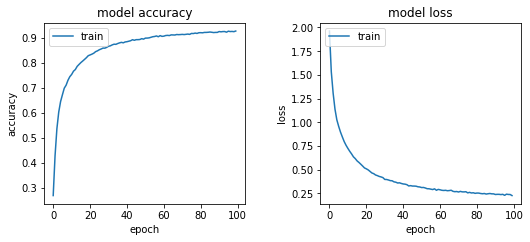

In [0]:
# For adam lr = 0.001 

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols=2, figsize = (8,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

In [0]:
print("Train time with adam 1e3:",int(getTrainingTime(time_callback.times)//60),"minutes")

83 minutes


dict_keys(['loss', 'accuracy'])


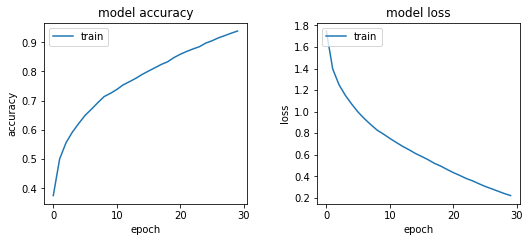

In [0]:
# For sgd lr = 0.001 m = 0.1

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols=2, figsize = (8,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['loss', 'accuracy'])


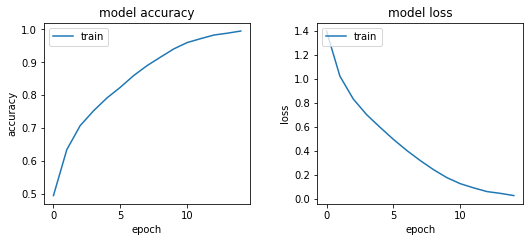

In [0]:
# For sgd lr = 0.001 m = 0.9

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols=2, figsize = (8,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['loss', 'accuracy'])


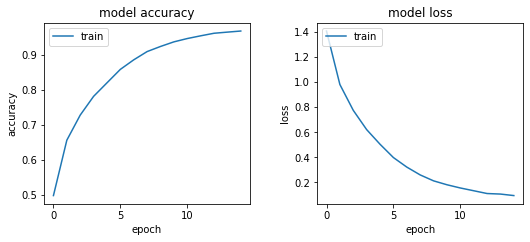

In [0]:
# For sgd lr = 0.01 m = 0.9

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols=2, figsize = (8,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['loss', 'accuracy', 'lr'])


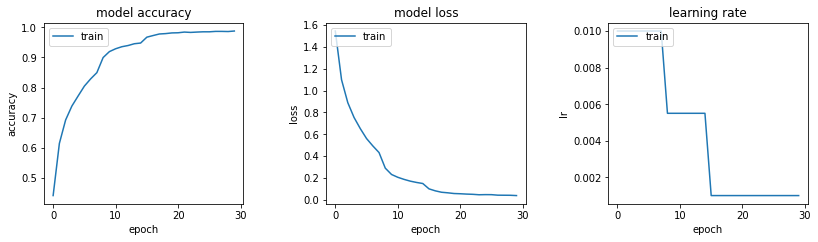

In [0]:
# For sgd lr = 0.01 m = 0.9 with rate scheduler and one dropout

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')

# summarizing history for loss on ax3
ax3.plot(history.history['lr'])
ax3.set_title('learning rate')
ax3.set_ylabel('lr')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'test'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['loss', 'accuracy', 'lr'])


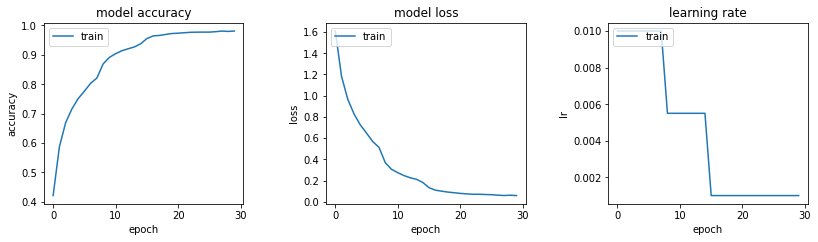

In [0]:
# For sgd lr = 0.01 m = 0.9 with rate scheduler and two dropouts 

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')

# summarizing history for loss on ax3
ax3.plot(history.history['lr'])
ax3.set_title('learning rate')
ax3.set_ylabel('lr')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'test'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


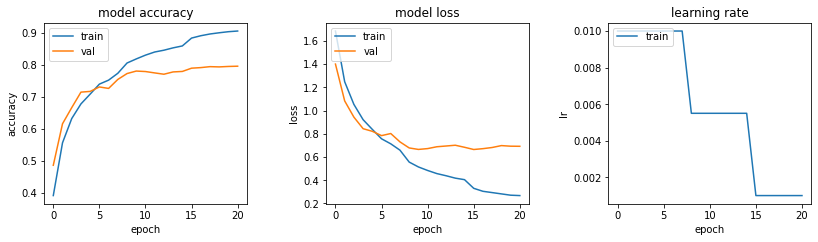

In [0]:
# For sgd lr = 0.01 m = 0.9 with first rate scheduler and four dropouts 

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax3
ax3.plot(history.history['lr'])
ax3.set_title('learning rate')
ax3.set_ylabel('lr')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'test'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


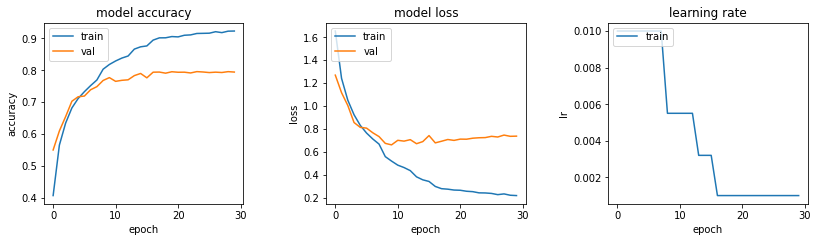

In [0]:
# For sgd lr = 0.01 m = 0.9 with second rate scheduler and four dropouts 

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax3
ax3.plot(history.history['lr'])
ax3.set_title('learning rate')
ax3.set_ylabel('lr')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'test'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


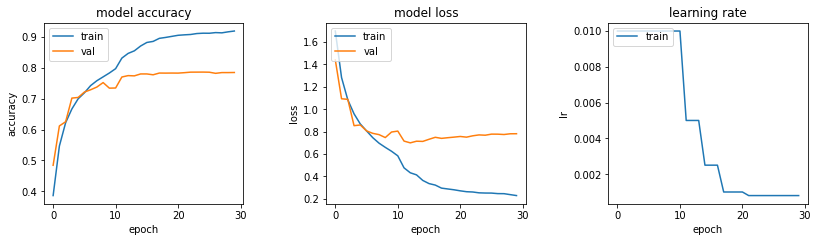

In [0]:
# For sgd lr = 0.01 m = 0.9 with third rate scheduler and four dropouts 

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax3
ax3.plot(history.history['lr'])
ax3.set_title('learning rate')
ax3.set_ylabel('lr')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'test'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


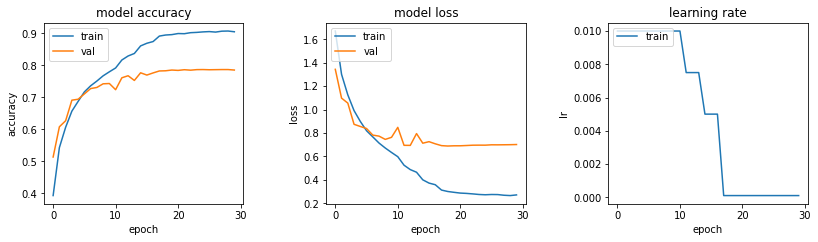

In [0]:
# For sgd lr = 0.01 m = 0.9 with fourth rate scheduler and four dropouts 

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax3
ax3.plot(history.history['lr'])
ax3.set_title('learning rate')
ax3.set_ylabel('lr')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'test'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


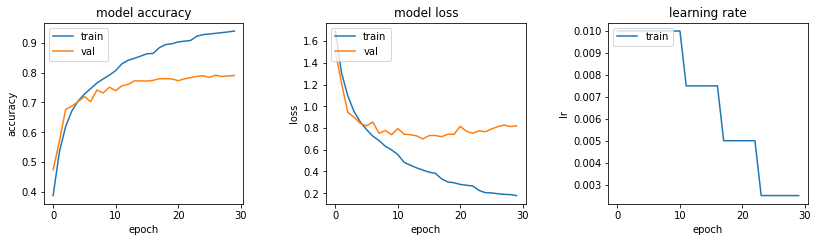

In [0]:
# For sgd lr = 0.01 m = 0.9 with newest rate scheduler and four dropouts 

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax3
ax3.plot(history.history['lr'])
ax3.set_title('learning rate')
ax3.set_ylabel('lr')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'test'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


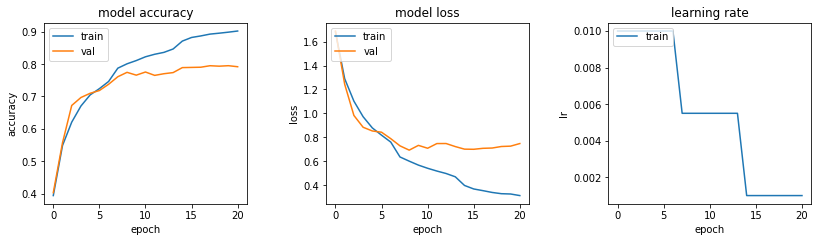

In [0]:
# For sgd lr = 0.01 m = 0.9 with first rate scheduler and four dropouts and kernel regularizer 1e-4 

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax3
ax3.plot(history.history['lr'])
ax3.set_title('learning rate')
ax3.set_ylabel('lr')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'test'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


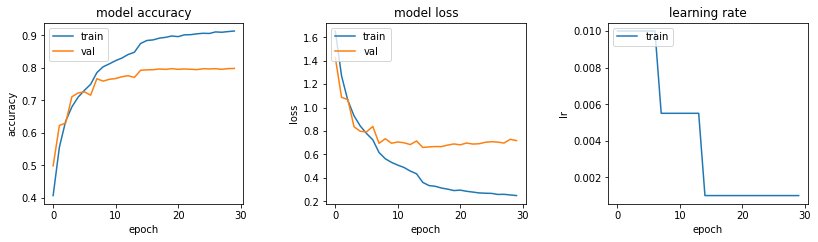

In [0]:
# For sgd lr = 0.01 m = 0.9 with first rate scheduler and four dropouts and kernel regularizer best till (1e-5)

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax3
ax3.plot(history.history['lr'])
ax3.set_title('learning rate')
ax3.set_ylabel('lr')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'test'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


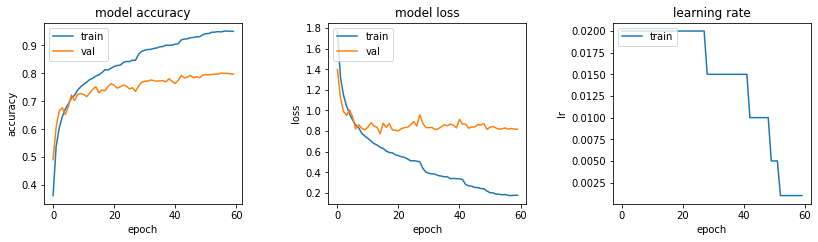

In [0]:
# For sgd lr = 0.01 m = 0.9 with 0.02 rate scheduler and four dropouts and kernel regularizer (1e-5)

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax3
ax3.plot(history.history['lr'])
ax3.set_title('learning rate')
ax3.set_ylabel('lr')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'test'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


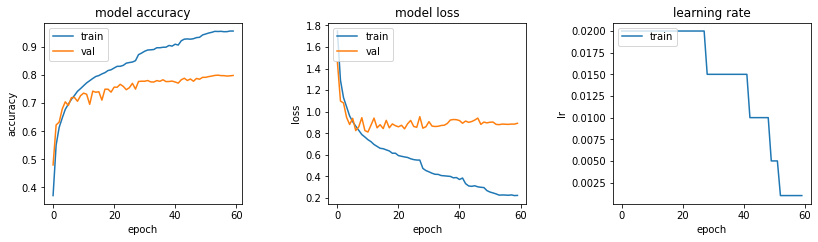

In [0]:
# For sgd lr = 0.01 m = 0.9 with 0.02 rate scheduler and four dropouts and kernel regularizer (1e-5)

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax3
ax3.plot(history.history['lr'])
ax3.set_title('learning rate')
ax3.set_ylabel('lr')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'test'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


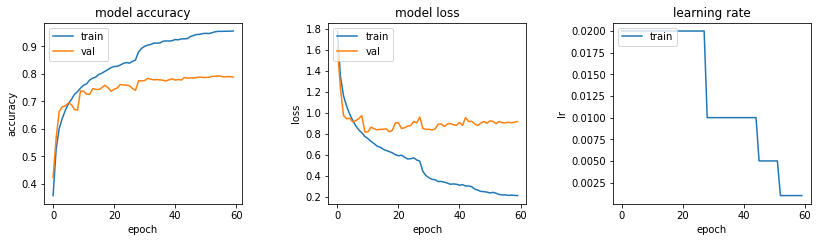

In [0]:
# For sgd lr = 0.01 m = 0.9 with newest rate scheduler and four dropouts and kernel regularizer (1e-5)

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax3
ax3.plot(history.history['lr'])
ax3.set_title('learning rate')
ax3.set_ylabel('lr')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'test'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


KeyError: ignored

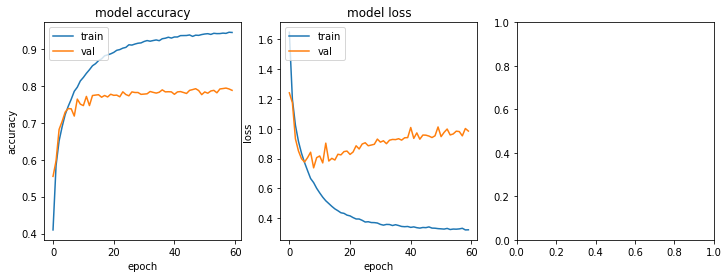

In [0]:
# For sgd lr = 0.01 m = 0.9 with adam and four dropouts and kernel regularizer (1e-5)

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax3
ax3.plot(history.history['lr'])
ax3.set_title('learning rate')
ax3.set_ylabel('lr')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'test'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


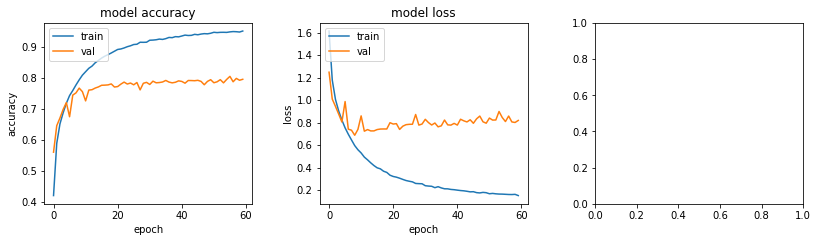

In [0]:
# For sgd lr = 0.01 m = 0.9 with adam lr = 0.001 and four dropouts

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


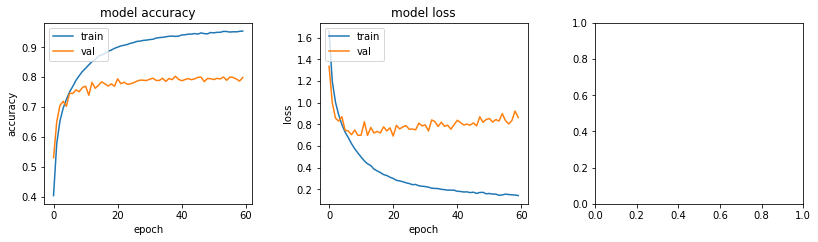

In [0]:
# For sgd lr = 0.01 m = 0.9 with adam lr = 0.01 and four dropouts

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


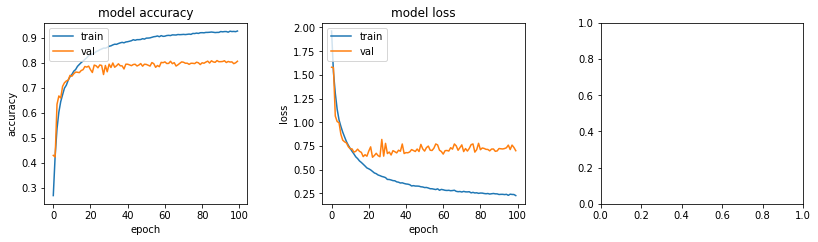

In [0]:
# For adam lr = 0.01 and four dropouts and 2 drpouts on 0.4 not 

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


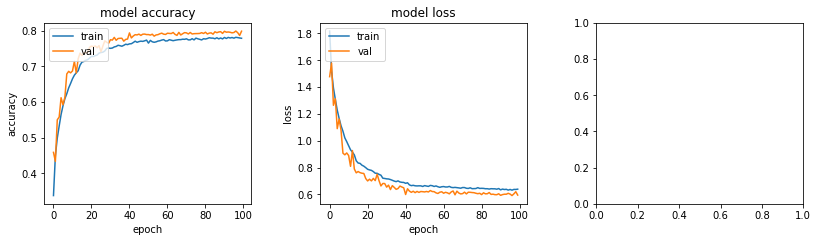

In [23]:
# For sgd and last rate schedulert all dropouts on 0.2 

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


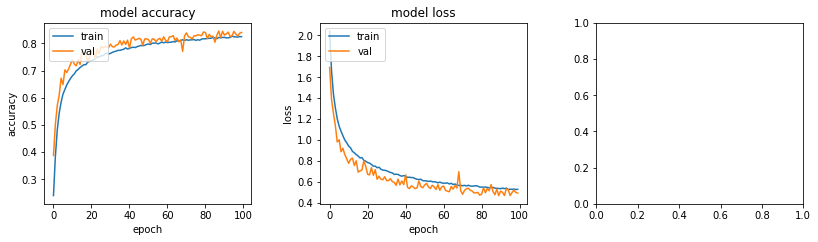

In [0]:
# For adam lr = 0.01 and four dropouts and 2 drpouts on 0.4 not 

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


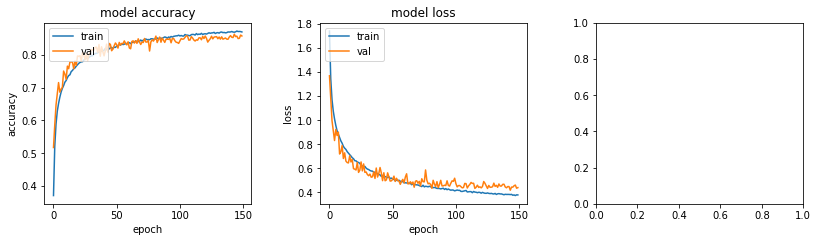

In [0]:
# For adam lr = 0.01 and four dropouts and all drpouts on 0.2

# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


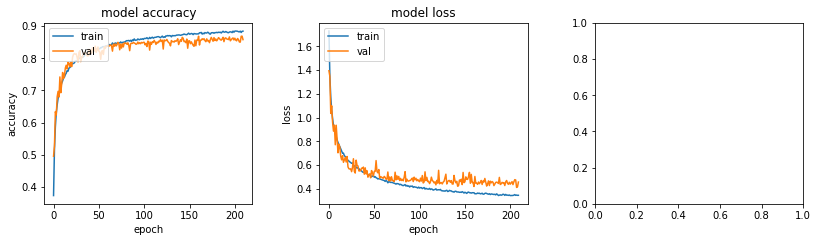

In [0]:
# For adam lr = 0.01 and four dropouts and all drpouts on 0.2  210 epochs
 
# list all data in history  
print(history.history.keys())


fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


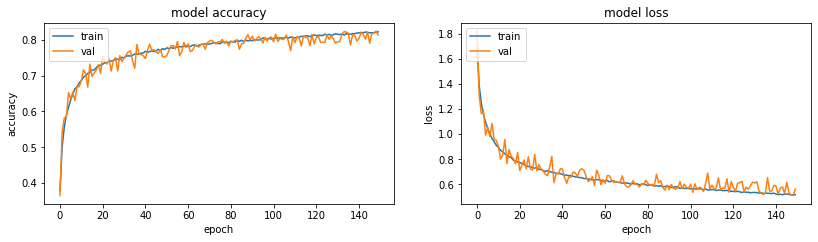

In [48]:
# For adam lr = 0.01 ,all drpouts on 0.2, 150 epochs with sigmoid activations
 
# list all data in history  
print(history.history.keys())


fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols=2, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


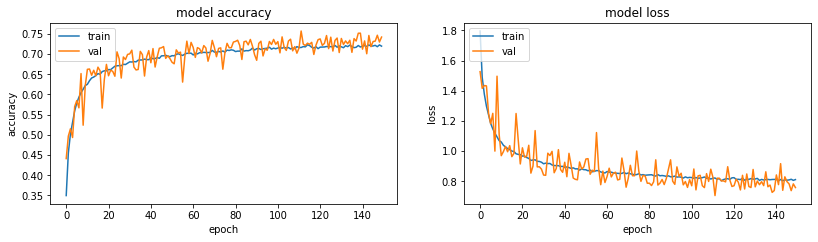

In [52]:
# For adam lr = 0.01 ,all drpouts on 0.2  150 epochs for tanh activations
 
# list all data in history  
print(history.history.keys())


fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols=2, figsize = (12,4))

# summarizing history for accuracy on ax1

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarizing history for loss on ax2
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.tight_layout(pad = 3.0)
plt.show()

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)       

In [41]:
# Final Testing with above model epochs  = 150 , Activations = Relu, DRopouts = 0.2, Optimizer = Adam with Image Augmentation

test_loss, test_accu = model.evaluate(x_test,y_test)
print("Loss: ",test_loss)
print("Accuracy: ",test_accu)

10000/10000 [==============================] - 1s 101us/step
Loss:  0.4717560818195343
Accuracy:  0.8476999998092651
